In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from tensorflow import keras
from collections import deque
import random
import time
from IPython import display
import warnings
import sys
from io import StringIO
warnings.filterwarnings('ignore')

# Sokoban

In [ ]:
import numpy as np
import gym
from gym import spaces

class SokobanEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, level=1):
        super(SokobanEnv, self).__init__()
        self.setup_level(level)
        self.height, self.width = self.map.shape
        self.player_position = self.find_player_position()
        self.action_space = spaces.Discrete(4)  # Four actions: 0=up, 1=down, 2=left, 3=right
        self.observation_space = spaces.Box(low=0, high=3, shape=(self.height, self.width), dtype=np.uint8)
        self.steps = 0
        self.max_steps = 100  # Define maximum number of steps per episode
        self.memory = []
        self.use_memory = True

    def map_to_str(self, map):
      return "\n".join(''.join(row) for row in map) + "\n"

    def map_to_int(self, map):
        # Define mapping from characters to integers
        char_to_int = {
            ' ': 0,  # Empty space
            '#': 1,  # Wall
            'O': 2,  # Target location for boxes
            '@': 3,  # Player
            '$': 4,  # Box,
            '!': 5   # Target location reached (box on top)
        }

        # Normalize values
        max_value = max(char_to_int.values())
        char_to_int = {char: value / max_value for char, value in char_to_int.items()}

        # Convert each character in the map to its corresponding integer value
        int_map = [[char_to_int[char] for char in row] for row in map]

        return np.array(int_map)

    def setup_level(self, level: int):
        self.level = level
        self.map = self.load_level(level)

    def load_level(self, level):
        return np.array([
            ['#', '#', '#', '#', '#', '#', '#', '#', '#', '#'],
            ['#', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '#'],
            ['#', ' ', 'O', ' ', ' ', ' ', ' ', ' ', ' ', '#'],
            ['#', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '#'],
            ['#', ' ', ' ', ' ', ' ', ' ', ' ', '$', ' ', '#'],
            ['#', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '@', '#'],
            ['#', '#', '#', '#', '#', '#', '#', '#', ' ', '#'],
            [' ', ' ', ' ', ' ', ' ', ' ', ' ', '#', '#', '#']
        ])

    def find_player_position(self):
        return np.array(np.where(self.map == '@'))[:, 0]

    def step(self, action):
        done = False
        self.steps += 1
        new_player_position = self.player_position.copy()

        if action == 0:  # Move up
            new_player_position -= [1, 0]
        elif action == 1:  # Move down
            new_player_position += [1, 0]
        elif action == 2:  # Move left
            new_player_position -= [0, 1]
        elif action == 3:  # Move right
            new_player_position += [0, 1]

        # Check if the new position is valid
        if self.map[tuple(new_player_position)] == '#':  # Wall
            reward = -.1
        elif self.map[tuple(new_player_position)] in [' ', 'O']:  # Empty space
            self.map[tuple(self.player_position)] = ' '
            self.map[tuple(new_player_position)] = '@'
            self.player_position = new_player_position
            reward = 0.01
        elif self.map[tuple(new_player_position)] == '$':  # Box
            box_new_position = new_player_position + (new_player_position - self.player_position)
            if self.map[tuple(box_new_position)] in ['#', '$']:  # Box cannot be moved
                reward = -.1
            elif self.map[tuple(box_new_position)] == 'O': # Box reached the right destination
                self.map[tuple(self.player_position)] = ' '
                self.map[tuple(new_player_position)] = '@'
                self.map[tuple(box_new_position)] = '!'
                reward = 1
                done = True
            else:
                self.map[tuple(self.player_position)] = ' '
                self.map[tuple(new_player_position)] = '@'
                self.map[tuple(box_new_position)] = '$'
                self.player_position = new_player_position
                reward = .2

        done = done or self.steps >= self.max_steps  # Game is done if the player reaches the target or maximum steps reached

        if self.use_memory:
          self.memory.append(self.map.copy())

        return self.map_to_int(self.map), reward, done, {}

    def reset(self):
        self.map = self.load_level(self.level)
        self.player_position = self.find_player_position()
        self.steps = 0
        self.memory = [self.map.copy()]
        return self.map_to_int(self.map)

    def render(self, mode='human'):
        if mode == 'human':
            display.clear_output(wait=True)
            print(self.map_to_str(self.map))
        else:
            outfile = sys.stdout
            outfile.write(self.map_to_str(self.map))
            return outfile

    def play_memory(self, framerate=2):
        for i, map in enumerate(self.memory):
            display.clear_output(wait=True)
            print("\n".join(''.join(row) for row in map) + "\n")
            if i != len(self.memory)-1:
              time.sleep(1/framerate)
        print("Replay over!")

    # Loads a game recorded on a txt file in memory
    def load_txt(self, filepath):
        with open(filepath, "r") as f:
            data = f.read()
            data = data.split('\n-\n')
            if data:
              self.reset()
              self.memory = []
            for map_str in data:
                if map_str:
                  map = map_str.split('\n')
                  self.memory.append(np.array([list(row) for row in map]))

    # Save a game in memory on a txt file
    def save_txt(self, filepath):
        if not self.memory:
            print(f"The memory is empty, nothing was saved in {filepath}")
        with open(filepath, "w") as f:
            for map in self.memory:
              f.write(self.map_to_str(map))
              f.write("-\n")
        print(f"The last game was successfully saved in {filepath}")

In [ ]:
game = SokobanEnv()
game.reset()
game.render()
game.render()

##########
#        #
# O      #
#        #
#      $ #
#       @#
######## #
       ###



In [ ]:
# game.save_txt("test.txt")

The last game was successfully saved in test.txt


In [ ]:
game.load_txt("test.txt")
game.play_memory()

FileNotFoundError: [Errno 2] No such file or directory: 'test.txt'

# The AI

In [ ]:
obs_count = game.map.size
action_count = game.action_space.n

In [ ]:
alpha = 0.001
model = keras.Sequential([
    keras.layers.Conv2D(64, kernel_size=(2, 2), activation='relu', input_shape=game.map.shape+(1,)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # keras.layers.Conv2D(64, kernel_size=(2, 2), activation='relu'),
    # keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(action_count, activation = 'linear')
])
# model.add(keras.layers.Dense(24, input_dim=obs_count, activation='relu'))
# model.add(keras.layers.Dense(24, activation='relu'))
# model.add(keras.layers.Dense(action_count, activation = 'linear'))
model.compile(loss = 'categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=alpha))

In [ ]:
model.predict(np.expand_dims(game.map_to_int(game.memory[0]), axis=0))

1/1 [==============================] - 0s 227ms/step


array([[-0.00669413,  0.02308736, -0.04499338,  0.038502  ]],
      dtype=float32)

In [ ]:
def experience_replay(model, batch_size, gamma, memory, obs_count, action_count, epoch_count, loss):
    for _ in range(epoch_count):
        batch = random.sample(memory, batch_size)      #sample a batch from the experience memory using batch_size
        batch_vector = np.array(batch, dtype=object)   #vectorise the batch

        obs_t = np.zeros((batch_size,) + batch_vector[0,0].shape)     #observation at t: create a numpy array of zeros with dimensions batch_size, state_count
        obs_t_next = np.zeros((batch_size,) + batch_vector[0,3].shape) #observation at t+1: create a numpy array of zeros with dimensions batch_size, state_count
        for i in range(len(batch_vector)):             #loop through the batch collecting the obs at t and obs at t+1
            obs_t[i] = batch_vector[i,0]               #store the observations at t in the relevant array
            obs_t_next[i] = batch_vector[i,3]          #store the observations at t+1 in the relevant array

        prediction_at_t = model.predict(obs_t, verbose=0)         #Use the model to predict an action using observations at t
        prediction_at_t_next = model.predict(obs_t_next, verbose=0)  #Use the model to predict an action using observations at t+1

        #Create the features(X) and lables(y)
        X = []                   #This is our feature vector, the most recent observation
        y = []                   #This is our label calculated using the long term discounted reward
        i = 0
        for obs_t, action, reward, _, done in batch_vector: #get a row from our batch

            X.append(obs_t)                          #append the most recent observation to X

            if done:                                 #if the episode was over
                target = reward                      #the target value is just the reward
            else:                                    #otherwise
                #the target value is the discounted optimal reward (Bellman optimality equation)
                #Remember we use the max action_value from the state(observation) at time t+1
                target = reward + gamma * np.max(prediction_at_t_next[i])

            #now we update the action value for the original state(observation) given the action that
            #was taken, and we use the target value as the update.
            prediction_at_t[i,action] = target
            #the updated action values are used as the label
            y.append(prediction_at_t[i])    #Remember the update will be used as the label to update the ANN weights
                                            #by backpropagating the mean squared error.

            i += 1                          #increment i

        h, w = batch_vector[0,0].shape
        X_train = np.array(X).reshape(batch_size, h, w)          #reshape X
        y_train = np.array(y)                                   #create a numpy array from y
        hist = model.fit(X_train, y_train, epochs = 1, verbose = 0) #fit the model with X,y and epochs
        for i in range(1):                             #loop over the epoch_count
            loss.append(hist.history['loss'][i])                 #record the loss for analysis

    return loss                                              #return the loss

In [ ]:
rewards = []                                              #store the rewards in a list for analysis only
loss = []                                                 #store the losses in a list for analysis only
episodes = 10                                             #We will start with 50 episodes and see how it goes
gamma = 0.3                                               #This is the discount rate
beta = 0.6                                                #This is the epsilon decay rate
batch_size = 8                                           #The batch size for solving the IID problem
memory = deque([], maxlen=250)                           #The memory replay buffer

In [ ]:
BEST_ACTIONS = [0]*1+[2]*5+[1]+[2]+[0]*2

In [ ]:
for episode in range(episodes):
    obs_t = game.reset()
    obs_t = np.expand_dims(obs_t, axis=0)
    # obs_t = np.reshape(obs_t, [1, obs_count]) # Flattens the map for the Dense layers

    total_reward = 0
    epsilon = .1
    epsilon = 1 / (1 + beta * (episode / action_count)) # Decreasing level of exploration over episodes

    i = 0

    done = False
    while not done:
        if episode%3==0:
          # Follows the "best actions"
          if i < len(BEST_ACTIONS):
              action = BEST_ACTIONS[i]
              i += 1
          else:
              action = game.action_space.sample()

        else:
          # Epsilon-greedy policy
          rand_num = np.random.random()
          if rand_num <= epsilon:
              action = game.action_space.sample() # Random action
          else:
              action_values = model.predict(obs_t, verbose=0)
              action = np.argmax(action_values[0]) # Best choice


        obs_t_next, reward, done, info = game.step(action)
        obs_t_next = np.expand_dims(obs_t_next, axis=0)
        # obs_t_next = np.reshape(obs_t_next, [1, obs_count]) # Flattens new state
        total_reward += reward
        memory.append((obs_t[0], action, reward, obs_t_next[0], done))
        obs_t = obs_t_next

        if done:
            rewards.append(total_reward)
            print(f'episode: {episode}/{episodes}, score: {total_reward}, epsilon: {epsilon}')

        if len(memory) > batch_size:
            loss = experience_replay(model, batch_size, gamma, memory, obs_count, action_count, 2, loss)

    rewards.append(total_reward)

episode: 0/10, score: 2.23, epsilon: 1.0
episode: 1/10, score: -2.4200000000000053, epsilon: 0.8695652173913044
episode: 2/10, score: -2.470000000000013, epsilon: 0.7692307692307692
episode: 3/10, score: 2.23, epsilon: 0.6896551724137931
episode: 4/10, score: -2.3600000000000034, epsilon: 0.625
episode: 5/10, score: -4.340000000000005, epsilon: 0.5714285714285714
episode: 6/10, score: 2.23, epsilon: 0.5263157894736842
episode: 7/10, score: -7.469999999999993, epsilon: 0.48780487804878053
episode: 8/10, score: -5.879999999999999, epsilon: 0.45454545454545453
episode: 9/10, score: 2.23, epsilon: 0.4255319148936171


In [ ]:
test_episodes = 1
all_rewards = []
for episode in range(test_episodes):
    obs_t = game.reset()
    obs_t = np.expand_dims(obs_t, axis=0)
    # obs_t = np.reshape(obs_t, [1, obs_count])
    total_reward = 0
    done = False

    while not done:
        action_values = model.predict(obs_t, verbose=0)
        action = np.argmax(action_values[0])
        obs_t_next, reward, done, _ = game.step(action)
        obs_t_next = np.expand_dims(obs_t_next, axis=0)
        # obs_t_next = np.reshape( obs_t_next, [1, obs_count])
        total_reward += reward

        obs_t = obs_t_next

        if done:
            all_rewards.append(total_reward)
            print(f'episode: {episode}/{test_episodes}, Total Reward: {total_reward}')

episode: 0/1, Total Reward: -9.99999999999998


In [ ]:
model.predict(np.expand_dims(game.map_to_int(game.memory[0]), axis=0))

1/1 [==============================] - 0s 22ms/step


array([[ 0.16398616,  0.4590819 , -0.83621997,  0.03082588]],
      dtype=float32)

In [ ]:
game.play_memory()

##########
#        #
# O      #
#        #
#      $ #
#        #
########@#
       ###

Replay over!


# Best scenario

In [ ]:
game.reset()
game.step(0) # Up
game.step(2) # Left
game.step(2) # Left
game.step(2) # Left
game.step(2) # Left
game.step(2) # Left
game.step(1) # Down
game.step(2) # Left
game.step(0) # Up
game.step(0) # Up

game.play_memory()

##########
#        #
# !      #
# @      #
#        #
#        #
######## #
       ###

Replay over!


# Draft

Y - [array([-0.00401568,  0.02612596,  0.06437387,  0.06924504], dtype=float32), array([ 0.12049172,  0.02512364, -0.04233185,  0.07403467], dtype=float32), array([0.09890187, 0.02794382, 0.07649329, 0.03662191], dtype=float32), array([0.10789525, 0.01424421, 0.08901168, 0.05986875], dtype=float32), array([0.00457083, 0.02571616, 0.0666312 , 0.02919756], dtype=float32), array([ 0.06232054,  0.02416056, -0.0372728 ,  0.09474081], dtype=float32), array([0.08499255, 0.00406835, 0.04439334, 0.0462661 ], dtype=float32), array([-0.00401568,  0.02612596,  0.06437387,  0.06924504], dtype=float32), array([-0.02704804,  0.0262778 , -0.08961536,  0.04932594], dtype=float32), array([0.06929757, 0.001078  , 0.09710573, 0.07152653], dtype=float32), array([ 0.12049172,  0.02512364, -0.04233185,  0.07403467], dtype=float32), array([-0.02704804,  0.0262778 , -0.08961536,  0.04932594], dtype=float32), array([ 1.        ,  0.05038005, -0.00438833,  0.13387969], dtype=float32), array([0.10789525, 0.014244

[2.7721099853515625, 2.735635995864868, 3.492513656616211]

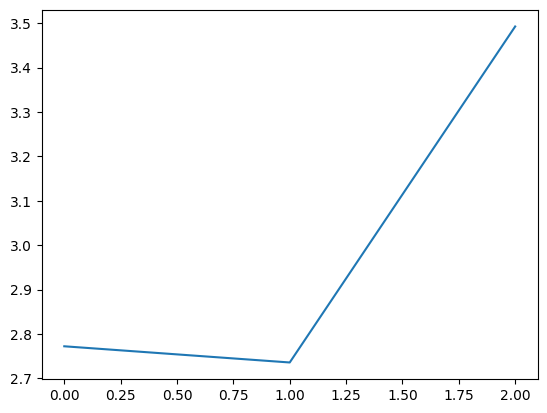

In [ ]:
loss = []
for _ in range(3):
    batch = random.sample(memory, batch_size)      #sample a batch from the experience memory using batch_size
    batch_vector = np.array(batch, dtype=object)   #vectorise the batch

    obs_t = np.zeros((batch_size,) + batch_vector[0,0].shape)     #observation at t: create a numpy array of zeros with dimensions batch_size, state_count
    obs_t_next = np.zeros((batch_size,) + batch_vector[0,3].shape) #observation at t+1: create a numpy array of zeros with dimensions batch_size, state_count
    for i in range(len(batch_vector)):             #loop through the batch collecting the obs at t and obs at t+1
        obs_t[i] = batch_vector[i,0]               #store the observations at t in the relevant array
        obs_t_next[i] = batch_vector[i,3]          #store the observations at t+1 in the relevant array

    prediction_at_t = model.predict(obs_t, verbose=0)         #Use the model to predict an action using observations at t
    prediction_at_t_next = model.predict(obs_t_next, verbose=0)  #Use the model to predict an action using observations at t+1

    #Create the features(X) and lables(y)
    X = []                   #This is our feature vector, the most recent observation
    y = []                   #This is our label calculated using the long term discounted reward
    i = 0
    for obs_t, action, reward, _, done in batch_vector: #get a row from our batch

        X.append(obs_t)                          #append the most recent observation to X

        if done:                                 #if the episode was over
            target = reward                      #the target value is just the reward
        else:                                    #otherwise
            #the target value is the discounted optimal reward (Bellman optimality equation)
            #Remember we use the max action_value from the state(observation) at time t+1
            target = reward + gamma * np.max(prediction_at_t_next[i])

        #now we update the action value for the original state(observation) given the action that
        #was taken, and we use the target value as the update.
        prediction_at_t[i,action] = target
        #the updated action values are used as the label
        y.append(prediction_at_t[i])    #Remember the update will be used as the label to update the ANN weights
                                        #by backpropagating the mean squared error.

        i += 1                          #increment i
    print(f"Y - {y}")
    h, w = batch_vector[0,0].shape
    X_train = np.array(X).reshape(batch_size, h, w)          #reshape X
    y_train = np.array(y)                                   #create a numpy array from y
    hist = model.fit(X_train, y_train, epochs = 1, verbose = 0) #fit the model with X,y and epochs
    for i in range(1):                             #loop over the epoch_count
        loss.append(hist.history['loss'][i])                 #record the loss for analysis
plt.plot(loss)
loss